In wanting to exactly simulate an FPGA implementation of a PFB in python, there was a need to develop a fixed-point number system class (since Python does not have one - especially one using numpy arrays).

The developed fixed-point class has the following properties:
 - bits: How many bits is the number to be represented by.
 - fraction: How many of those bits are used to represent the fraction.
 - min_int: Optionally specify the minimum integer representable.
 - max_int: Optionally specify the maximum integer representable.
 - unsigned: Defaults to being a signed number, but can be set "True" to make unsigned.
 - offset: A DC offset, where the default offset is 0.5.
 - FPTYPE: Type of integer the fixed point number is held as i.e. int64, int32 etc...

How we store an input float, is to clip (i.e all numbers larger/less than a max/min = that max/min), scale (i.e. left shifted until entire fractional part is part of the integer) and round/truncate so as to remove all the rest of the fractional part and hold the number as an integer. For example, for bits = 8 and fraction =  6:
\begin{equation}{
    \textrm{(float) } 2.569 => \textrm{ (float) } 2.569\times 2^{6} => \textrm{ (float) } 164.416 => \textrm{ (FPTYPE) } 164
}\end{equation}

The rest of the methods extend the functionality of the Fixed Point number system developed by adapting numpy addition, multiplication, subtraction, indexing, copying and printing.

Methods are further included to allow for re-quantisation (re-casting the fixed point number with new fraction and bit sizes) and right/left shifting.

Below one can see how to implement a fixpoint number as well as see that values are being represented/operated on correctly.

In [1]:
import numpy as np
from fixpoint import fixpoint as fp

a_list = fp(10,9)
a_list.from_float(np.array([1.99,0.01,0.223]))
b_list = fp(10,9)
b_list.from_float(np.array([0.22,0.488,0.919]))
print("OUTPUT:")
print("a_list: ",a_list.data," as float: ",a_list.to_float()) #show a_list
print("b_list: ",b_list.data," as float: ",b_list.to_float()) #show b_list
print("a_list+b_list: ",(a_list+b_list).data," as float: ",(a_list+b_list).to_float()) #show a_list+b_list
print("a_list-b_list: ",(a_list-b_list).data," as float: ",(a_list-b_list).to_float()) #show a_list-b_list
print("a_list*b_list: ",(a_list*b_list).data," as float: ",(a_list*b_list).to_float()) #show a_list*b_list

a_newlistclip = a_list.quantise(5,4) #quantise a_list down to bits=5 and fraction = 4
print("a_list after quantising: ",a_newlistclip.data," as float: ",a_newlistclip.to_float()) #show a_list quantised

a_newlist = a_list>>1 #right shift a_list by 1 (i.e. divide by 2)
print("a_list after right shifting: ",a_newlist.data," as float: ",a_newlist.to_float()) #show a_list shifted down by 1

b_newlist = a_newlist.copy()
print("b_list, a copy of a_list: ",b_newlist.data," as float: ",a_newlist.to_float()) #show b_list

OUTPUT:
a_list:  [511   5 114]  as float:  [0.99804688 0.00976562 0.22265625]
b_list:  [113 250 471]  as float:  [0.22070312 0.48828125 0.91992188]
a_list+b_list:  [624 255 585]  as float:  [1.21875    0.49804688 1.14257812]
a_list-b_list:  [ 398 -245 -357]  as float:  [ 0.77734375 -0.47851562 -0.69726562]
a_list*b_list:  [57743  1250 53694]  as float:  [0.22027206 0.00476837 0.20482635]
a_list after quantising:  [15  0  4]  as float:  [0.9375 0.     0.25  ]
a_list after right shifting:  [256   2  57]  as float:  [0.5        0.00390625 0.11132812]
b_list, a copy of a_list:  [256   2  57]  as float:  [0.5        0.00390625 0.11132812]


We see that the numbers are behaving in a correct fashion with only slight deviations from what would be produced if done in standard floating point. Re-quantising works, but we also run the risk of having the values clip if the Integer World Length (IWL) is decreased (i.e. oldbits - oldfraction > newbits - new fraction). Right shifting also works and is used to re-quantise without clipping.

Once having developed the fixed point number system, it was extended to a fixed point complex number system by storing the imaginary and real components as two separate fixed point numbers. All mathematics is then done in a complex manner and all other operations are simply extended to the complex regime. 

Running some tests:

In [2]:
from fixpoint import fixpoint as fp, cfixpoint as cfp

a_list = cfp(10,9)
a_list.from_complex(np.array([1.99+1j,0.01-0.001j,0.223-0.88j]))
b_list = cfp(10,9)
b_list.from_complex(np.array([0.22+0.44j,0.48+0.66j,0.91+0.123j]))
print("OUTPUT:")
print("a_list: ",a_list.data," as float: ",a_list.to_complex()) #show a_list
print("b_list: ",b_list.data," as float: ",b_list.to_complex()) #show b_list
print("a_list+b_list: ",(a_list+b_list).data," as float: ",(a_list+b_list).to_complex()) #show a_list+b_list
print("a_list-b_list: ",(a_list-b_list).data," as float: ",(a_list-b_list).to_complex()) #show a_list-b_list
print("a_list*b_list: ",(a_list*b_list).data," as float: ",(a_list*b_list).to_complex()) #show a_list*b_list




a_newlistclip = a_list.quantise(5,4) #quantise a_list down to bits=5 and fraction = 4
print("a_list after quantising: ",a_newlistclip.data," as float: ",a_newlistclip.to_complex())

a_newlist = a_list>>1 #right shift a_list by 1 (i.e. divide by 2)
print("a_list after right shifting: ",a_newlist.data," as float: ",a_newlist.to_complex())

b_newlist = a_newlist.copy()
print("b_list, a copy of a_list: ",b_newlist.data," as float: ",a_newlist.to_complex()) #show b_list

OUTPUT:
a_list:  [511.+511.j   5.  -1.j 114.-451.j]  as float:  [0.99804688+0.99804688j 0.00976562-0.00195312j 0.22265625-0.88085938j]
b_list:  [113.+225.j 246.+338.j 466. +63.j]  as float:  [0.22070312+0.43945312j 0.48046875+0.66015625j 0.91015625+0.12304688j]
a_list+b_list:  [624.+736.j 251.+337.j 580.-388.j]  as float:  [1.21875   +1.4375j     0.49023438+0.65820312j 1.1328125 -0.7578125j ]
a_list-b_list:  [ 398.+286.j -241.-339.j -352.-514.j]  as float:  [ 0.77734375+0.55859375j -0.47070312-0.66210938j -0.6875    -1.00390625j]
a_list*b_list:  [-57232.+172718.j   1568.  +1444.j  81537.-202984.j]  as float:  [-0.21832275+0.65886688j  0.00598145+0.00550842j  0.31103897-0.77432251j]
a_list after quantising:  [15.+15.j  0. +0.j  4.-14.j]  as float:  [0.9375+0.9375j 0.    +0.j     0.25  -0.875j ]
a_list after right shifting:  [256.+256.j   2.  +0.j  57.-226.j]  as float:  [0.5       +0.5j        0.00390625+0.j         0.11132812-0.44140625j]
b_list, a copy of a_list:  [256.+256.j   2.  +0

We see the tests pass.

The PFB was first developed in floating-point so as to design the overall system before implementing the more complicated fixed-point counterpart.

The most essential structure in the PFB is the FFT. The architecture used in MeerKAT is a Radix 2 DIT FFT. Originally I had tried to implement it recursively, but in order to better understand signal flow, the iterative technique is used here. Importantly,with MeerKAT all input data is $<\pm 1$ and prior to insertion into the F-Engine, is scaled to be $<\pm 0.5$ so as to not have overflow when doing the first stage of additions.  

Below are some important notes regarding finite precision arithmetic:

ADDITION:
 - scales (where $scale = 2^{fraction}$) must be the same to add the fixed point numbers.
 - to make scales the same, I requantise the number with a  smaller scale to the larger scale (to not lose precision). i.e. if a has scale R and b has scale S, for R<S, $a = a\times\frac{S}{R}$. Addition is then performed after.
 - the result is a number of its inputs bit length + 1. Hence we have a bit growth of 1. In the special case of MeerKAT, where all input data is $<\pm 0.5$, we hope that this additional bit won't be populated.
 
MULTIPLICATION:
 - scales needn't be the same.
 - for a with bits = N and fraction = M, and b with bits = V and fraction = W, multiplication returns number of bits = N+V and fraction = M+W. The scale of the new number is $2^{M+W}$. However for the special case of MeerKAT, we will only have bit growth to the right (since the numbers we multiply are $<\pm 0.5$).

HOW TO FFT-SHIFT/REQUANTISE:

The current idea is that in the butterfly operations $A - \omega \times B$ and $A + \omega \times B$, the multiplication of $\omega \times B$ will grow the data to the right by a certain number of bits - which are then simply sliced off (with rounding) to maintain bit precision. The addition should then be that of 2 numbers $<\pm 0.5$. After addition we should have +1 bits. If we FFT shift, we then get -1 bits and -1 fraction, then normalise to original i.e. pad with zero in LSB. If we dont, we normalise, thereby removing MSB. The FFT is created to accept a register as with MeerKAT that accepts a binary register which either will initiate an FFT shift at a stage if $=1$, or not if $=0$. The FFT used within the PFB is a natural order in, bit reversed order out FFT, and so the function bit_rev is used to turn the FFT output back into its natural order. Below is a test of this:


In [3]:
from pfb_floating import *

So the bit reversal of 6 for a 3 bit system is (i.e. 8-pt FFT):

In [4]:
inparray = np.array([0,4,2,6,1,5,3,7])
bit_rev(inparray,3)

array([0, 1, 2, 3, 4, 5, 6, 7])

which produces a natural order output.

bit_rev is used to re-index the output of the FFT in parallel.


This ordering does the odd/even separation required for radix 2 decimation in time (DIT) and decimation in frequency (DIF) algorithms. MeerKAT reorders the data after the fft as opposed to before, and uses DIT. For comparison, below is a bit-reversed order in and natural order out FFT, followed by the natural order in, bit-reversed order out. Both are DIT algorithms.

In [5]:
def iterfft_bitorder_in_DIT(a):
    N=len(a)                                   #how long is data stream
    A=bitrevarray(a,N)                         #bit reorder input data prior to processing
    for stage in range(1,int(np.log2(N))+1):   #iterate through stages
        subarraylen = 2**stage                 #size of sub-array being processed - will decrease if natural order in, else it increases 
                                               #(i.e. prior decimation vs post decimation).
        w_m = np.exp(-2*np.pi*1j/subarraylen)  #twiddle factor base
        distance = int(subarraylen/2)          #distance between input arms to butterflies
        for k in range(0,N,subarraylen):       #iterate through all sub arrays
            w=1                                #start at 1
            for j in range(0,distance):        #iterate through each pair of arms in butterflies
                t= w*A[k+j+distance]           #one butterfly input arm
                u = A[k+j]                     #other butterfly input arm
                A[k+j]=u+t                     #one butterfly output arm
                A[k+j+distance]=u-t            #other butterfly output arm
                w=w*w_m                        #update twiddle factor - rotate it for next iteration
    return A

Comparing with the numpy fft for 16-bit data of a cosine wave we get:

In [6]:
import matplotlib.pyplot as plt
nnn = 1024
cos = (np.cos(8*np.pi*np.arange(nnn)/nnn))/8.001
sig = cos+1j*(np.cos(128*np.pi*np.arange(nnn)/nnn))/8.001
rect = np.zeros(1024)
rect[1:10]=1
plt.plot(np.arange(nnn),np.abs(iterfft_bitorder_in_DIT(sig)),'r',label='Our iterative FFT')
plt.plot(np.arange(nnn),np.abs(np.fft.fft(sig)),'g',label='Numpy FFT')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

Great, so the fft's match (nearly exactly which is why you cannot see red so well).
Now we implement a natural order in, bit-reverse order out iterative DIT fft (as used by MeerKAT). The function maketwiddle is used pre-generate the twiddle factors so as to speed up compute, and while this is different to the MeerKAT FPGA implementation (due to memory constraints) it does not cause any discrepancy:

In [7]:
def iterfft_natural_in_DIT(DATA,twid,staged=False):
    data = np.asarray(DATA,dtype = np.complex64)
    N = data.shape[0]                                                          #how long is data stream
    
    if(staged):
        stgd_data = np.zeros((N,int(np.log2(N))+2),dtype = np.complex64)
        stgd_data[:,0] = data[:]
    num_of_groups = 1                                                          #number of groups - how many subarrays are there?
    distance = N//2                                                            #how far between each fft arm?
    stg=1                                                                      #stage counter
    
    while num_of_groups < N:                                                   #basically iterates through stages
        for k in range(num_of_groups):                                         #iterate through each subarray
            jfirst = 2*k*distance                                              #index to beginning of a group
            jlast = jfirst + distance - 1                                      #first index plus offset - used to index whole group
            W=twid[k]
            slc1 = slice(jfirst,jlast+1,1)
            slc2 = slice(jfirst+distance, jlast+1+distance,1)
            tmp = W*data[slc2]
            data[slc2] = data[slc1]-tmp
            data[slc1] = data[slc1]+tmp
        num_of_groups *=2
        distance //=2
        if(staged):                                                            #if we are recording stages
            stgd_data[:,stg]=data[:]                                           #log each stage data to array
        stg+=1
        
    if(staged): 
        stgd_data[:,-1] = bitrevarray(stgd_data[:,-2],N)                       #post bit-reordering for last stage - added as extra stage
        return stgd_data
    else:
        A=bitrevarray(data,N)                                                  #post bit-reordering
        return A

        

testing as with above.

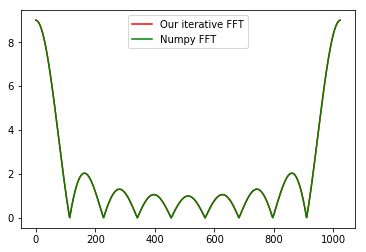

In [8]:
w = make_twiddle(nnn)
w = bitrevarray(w,w.size)
plt.plot(np.abs(iterfft_natural_in_DIT(rect,w)),'r',label='Our iterative FFT')
plt.plot(np.abs(np.fft.fft(rect)),'g',label='Numpy FFT')
plt.legend()
plt.show()

which again works well. Now that floating point implementation works, a fixed point implementation was developed. Below is pasted the code for the MeerKAT fixed-point FFT. This implementation includes all shifting and requantisation schemes according to MeerKAT.

In [9]:
def iterffft_natural_DIT(DATA,twid,shiftreg,bits,fraction,staged=False):       #parse in data,tiddle factors (must be in bit reversed order for natural order in),
                                                                               #how many bits fixpoint numbers are, fraction bits they are, offset, and rounding scheme.
    data=DATA.copy()
    N = data.data.shape[0]                                                     #how long is data stream
    if(staged):
        stgd_data = DATA.copy()
        stgd_data.from_complex(np.zeros((N,int(np.log2(N))+2),
                                        dtype = np.complex64))
        stgd_data[:,0] = data[:]                                                     
    stages = int(np.log2(N))
    if(len(shiftreg)!=stages and type(shiftreg) is not list):
        raise ValueError("Shift register must be of type list, and its length "
                         +"must be log2(data length)")
        
    num_of_groups = 1                                                          #number of groups - how many subarrays are there?
    distance = N//2                                                            #how far between each fft arm?
    stg=1                                                                      #stage counter
    while num_of_groups < N:                                                   #basically iterates through stages
        for k in range(num_of_groups):                                         #iterate through each subarray
            jfirst = 2*k*distance                                              #index to beginning of a group
            jlast = jfirst + distance - 1                                      #first index plus offset - used to index whole group
            W=twid[k]

            slc1 = slice(jfirst,jlast+1,1)
            slc2 = slice(jfirst+distance, jlast+1+distance,1)
            tmp = (W * data[slc2]) >> bits - 1                                 #slice off lower bit growth from multiply
            tmp.bits =bits                                                     #bits will = 2*bits+1 - hence - (bits+1)
            tmp.fraction=fraction                                              #fraction will = 2*(frac1+frac2) - hence - (bits-1)
            tmp.normalise()
            data[slc2] = data[slc1]-tmp
            data[slc1] = data[slc1]+tmp
            
        if shiftreg.pop():                                                     #implement FFT shift and then normalise to correct at end of stage
            data>>1
        data.normalise()
        
        num_of_groups *=2
        distance //=2
        if(staged):                                                            #if we are recording stages
            stgd_data[:,stg]=data[:]                                           #log each stage data to array
        stg+=1
        
    if(staged): 
        stgd_data[:,-1] = bitrevfixarray(stgd_data[:,-2],N)                    #post bit-reordering for last stage - added as extra stage
        return stgd_data
    else:
        return bitrevfixarray(data,N)                                          #post bit-reordering

Testing it on a cosine in a similar way to the floating point instance:

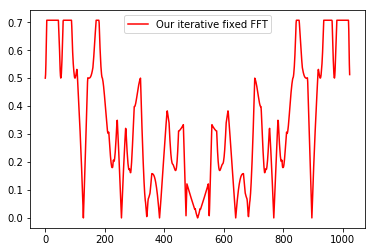

In [10]:
from pfb_fixed import *
bits = 20
fixsig = cfp(bits,bits,offset=0.0,method="TRUNCATE")                             #our cosine will be
fixsig.from_complex(rect)                                                         #get data in
shiftreg = [0,0,0,0,0,0,0,0,0,0]                                                 #make 64 bit shiftregister
twiddles = make_fix_twiddle(nnn,bits,bits-1)                                     #make fixpoint twiddle factors
twiddles = bitrevfixarray(twiddles,twiddles.data.size)                           #reverse order them 
FFFTcos = iterffft_natural_DIT(fixsig,twiddles,shiftreg,bits,bits)               #perform fixed point fft
absFFFTcos = np.abs(FFFTcos.to_complex())
plt.plot(absFFFTcos,'r',label='Our iterative fixed FFT')
plt.legend()
plt.show()

Looks very unlike the floating point implementations doesn't it? This is due to overflow within the FFT. If we now aggressively shift the signal, we get:

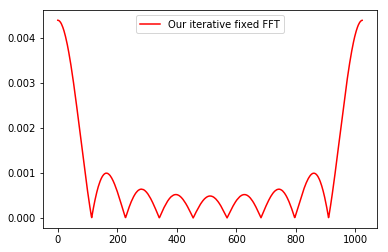

In [11]:
shiftreg = [1,1,1,1,1,1,1,1,1,1]
FFFTcos = iterffft_natural_DIT(fixsig,twiddles,shiftreg,bits,bits)               #perform fixed point fft
absFFFTcos = np.abs(FFFTcos.to_complex())
plt.plot(absFFFTcos,'r',label='Our iterative fixed FFT')
plt.legend()
plt.show()

This looks (other than in magnitude) the same as the floating point implementation. This is because the aggressive shifting has prevented overflow - while also reducing our signals magnitude.

Let's now consider the floating and fixed polyphase filterbanks. These combine a FIR filterbank with the implemented FFT's.

Taking a sin input signal:

Text(0.5, 1.0, 'Sin input signal')

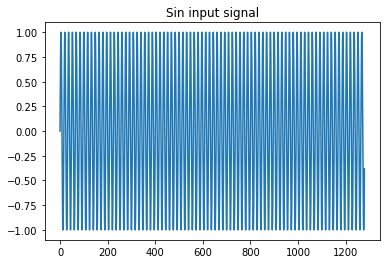

In [12]:
sin = np.sin(160*np.pi*np.arange(1280)/1280)
plt.plot(np.arange(1280),sin)
plt.title('Sin input signal')

Say we want to process the above signal using a 64-pt, 4 tap pfb with no averaging, and accepts a single polarisation. We'd declare this pfb as:

In [13]:
pfb_float_single = FloatPFB(64,4)

and run the data through it and display the last output as:

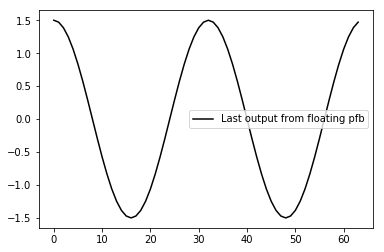

In [14]:
impulse = np.zeros(1280)
slc =  slice(1,1280,64)
impulse[slc] = 1
pfb_float_single.run(impulse)
output = np.real(pfb_float_single.X_k[:,-1])
plt.plot(output,'k',label = "Last output from floating pfb")
plt.legend()
plt.show()

Comparing the above with the numpy transform of a cosine wave we get:

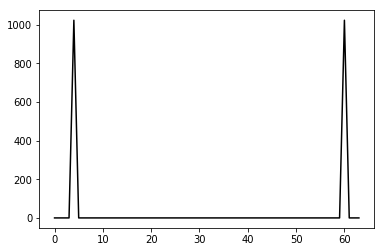

In [15]:
plt.plot(np.arange(64),np.absolute(np.fft.fft(np.sin(8*np.pi*np.arange(64)/64)))[:]**2,'k')

Which produces spikes in the same places, but just of lower amplitude due to the numpy fft operating on a 20th of the data.
Checking a dual polarisation - i.e the following signal:

In [16]:
sig = sin+1j*impulse

Which is the combination of a rectangular and cosine function. We declare as:

In [17]:
pfb_float_dual = FloatPFB(64,8,dual = True)

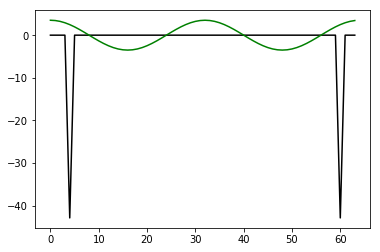

In [18]:
pfb_float_dual.run(sig)
output1 = pfb_float_dual.G_k[:,-1]
output2 = pfb_float_dual.H_k[:,-1]
plt.plot(np.real(output1),'k',np.real(output2),'g')
plt.show()

Which shows the splitting works fine. We get the two complex transforms of the input real signals back.

In [19]:
from pfb_fixed import *

The above PFB is implemented to take a cfixpoint data stream, and operate on it. The bits in/out integers specified determine what precision the input/output data is kept at. The same goes for the specifying of the offset, rounding method and whether unsigned or not. Below we mimick the test run on the floating point PFB with 10 bits in, 18 bits out and signed numbers. We also specify the shift register for the FFT to be all 1's so we shift right on every iteration.

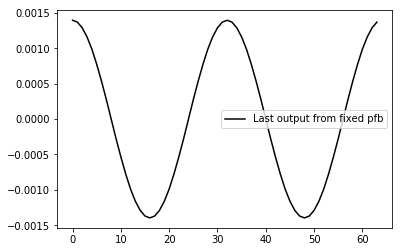

In [20]:
fiximpulse = cfixpoint(10,10)
impulse /=2.1
fiximpulse.from_complex(impulse)
reg = [1,1,1,1,1,1]
fpfb = FixPFB(N=64,taps=4,bits_in=10,bits_out=18,shiftreg = reg)
fpfb.run(fiximpulse)
output = fpfb.X_k.to_complex()
plt.plot(np.real(output[:,-1]),'k',label = "Last output from fixed pfb")
plt.legend()

Since we are using signed fixed point (10,10), we need to scale so no value in signal is $>\pm0.5$. 
Checking dual polarisations now, without averaging:

In [21]:
csig=cfixpoint(10,10)
sig/=2.1
csig.from_complex(sig) #get out complex signal - same as earlier test
fpfbdual = FixPFB(N=64,taps=4,bits_in=10,bits_out=18,shiftreg = reg,dual =True)
fpfbdual.run(csig)

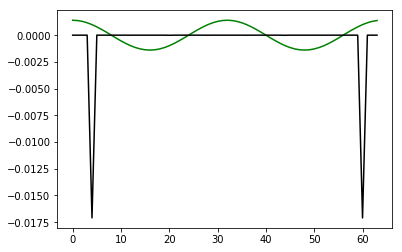

In [23]:
output1 = fpfbdual.H_k.to_complex()[:,-1]
output2 = fpfbdual.G_k.to_complex()[:,-1]
plt.plot(np.real(output1),'g',np.real(output2),'k')
plt.show()

Which is exactly the same result as for the floating point implementation with different scaling.